Copyright (c) MONAI Consortium
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Canalización de Hugging Face para MONAI

[Hugging Face](https://huggingface.co/) es una popular plataforma de código abierto para el procesamiento del lenguaje natural (PLN) y otras aplicaciones de aprendizaje automático. Sus herramientas y bibliotecas están diseñadas para facilitar el uso de modelos de última generación para una amplia gama de tareas. Proporciona modelos preentrenados y una API fácil de usar, lo que hace que el aprendizaje automático de vanguardia sea accesible para desarrolladores e investigadores por igual.

La biblioteca [Transformers](https://huggingface.co/docs/transformers/index) de Hugging Face es una colección completa de modelos preentrenados para PNL y otras tareas. Admite modelos para clasificación de texto, extracción de información, respuesta a preguntas, resumen, traducción y más. La biblioteca está diseñada para ser fácil de usar, permitiendo a los usuarios integrar fácilmente potentes modelos en sus aplicaciones con solo unas pocas líneas de código.

El [Hugging Face Hub](https://huggingface.co/docs/hub/index) es una plataforma en línea donde los usuarios pueden compartir y descubrir modelos preentrenados. Alberga modelos para varios idiomas y tareas, lo que permite la colaboración y la reutilización de modelos dentro de la comunidad de aprendizaje automático. El Hub también proporciona herramientas para versionar, gestionar y desplegar modelos, lo que lo convierte en un recurso valioso tanto para desarrolladores como para investigadores.

En este tutorial, un modelo de segmentación de bazo preentrenado se envolverá en una canalización proporcionada por la biblioteca Transformers. Siguiendo este tutorial, como se muestra en la figura a continuación, los usuarios pueden construir fácilmente sus propios modelos discriminativos de MONAI (clasificación, detección, segmentación) en una canalización de transformadores y permitir que otros lo usen como una canalización nativa de Transformers de Hugging Face de forma transparente para construir aplicaciones.

<center>
    <img src="../figures/hugging_face_general.jpg" alt="drawing" width=650 />
</center>

Esta celda introductoria describe las tecnologías que se utilizarán, como Hugging Face y su biblioteca Transformers, y establece el objetivo del tutorial: integrar un modelo de segmentación de MONAI en una canalización de Hugging Face.

## Configurar el entorno
La instalación de MONAI tiene las dependencias opcionales necesarias para este tutorial. Por lo tanto, se recomienda instalar MONAI con las dependencias opcionales necesarias para este tutorial.

Esta celda explica que para ejecutar el tutorial, es necesario instalar MONAI junto con algunas de sus dependencias opcionales, que incluyen `transformers`, `skimage` y `nibabel`.

In [1]:
!python -c "import monai" || pip install -q 'monai[transformers,skimage,nibabel]'

## Configurar importaciones

En esta celda se importan todas las bibliotecas y módulos necesarios para el tutorial, incluyendo `monai`, `torch`, `numpy`, `matplotlib` y `transformers`.

In [2]:
import logging

from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    LoadImage,
    LoadImaged,
    Orientationd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    ToNumpy,
    Invertd,
)

from monai.utils.enums import CommonKeys as Keys
from monai.networks.nets import UNet
from monai.networks.utils import eval_mode
from monai.inferers import SlidingWindowInferer
from monai.data import decollate_batch, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from monai.bundle import download
import torch
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import shutil

from transformers import PretrainedConfig, PreTrainedModel, Pipeline

print_config()

MONAI version: 1.5.0
Numpy version: 2.3.1
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: /tmp/MedicalImage-PGTD/.venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: 0.25.2
scipy version: 1.16.0
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: 1.7.2
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: 4.53.2
mlflow version: 3.1.1
pynrrd version: 1.1.3
clearml version: 2.0.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Configurar el directorio de datos

Puede especificar un directorio con la variable de entorno `MONAI_DATA_DIRECTORY`. Esto le permite guardar resultados y reutilizar descargas. Si no se especifica, se utilizará un directorio temporal.

Esta sección muestra cómo configurar un directorio para almacenar los datos del tutorial. Usar una variable de entorno como `MONAI_DATA_DIRECTORY` es una buena práctica para mantener los datos organizados y reutilizables.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpmgoj4wzp


## Descargar el conjunto de datos

Descarga y extrae el conjunto de datos. El conjunto de datos proviene de http://medicaldecathlon.com/.

Aquí se descarga el conjunto de datos de la competición Medical Segmentation Decathlon, específicamente la Tarea 09, que corresponde a la segmentación del bazo. La función `download_and_extract` de MONAI se encarga de la descarga y descompresión.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [16:09, 1.66MB/s]                               

2025-07-15 21:27:51,650 - INFO - Downloaded: /tmp/tmpmgoj4wzp/Task09_Spleen.tar


2025-07-15 21:27:53,857 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2025-07-15 21:27:53,857 - INFO - Writing into directory: /tmp/tmpmgoj4wzp.
2025-07-15 21:27:53,857 - INFO - Writing into directory: /tmp/tmpmgoj4wzp.


## Obtener el conjunto de datos de inferencia

En esta celda, se preparan los datos para la inferencia. Se buscan todas las imágenes de prueba (en formato NIfTI) en el directorio descargado y se crea una lista de diccionarios, donde cada diccionario apunta a la ruta de una imagen.

In [5]:
images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
data_dicts = [{"image": image_name} for image_name in images]

## Definir la configuración del modelo

Una `PretrainedConfig` en la biblioteca Transformers de Hugging Face es una clase que contiene los parámetros de configuración para un modelo. Esta configuración incluye información como detalles de la arquitectura del modelo, hiperparámetros y otras configuraciones que definen cómo se comporta el modelo. La `PretrainedConfig` se utiliza para inicializar un modelo con una configuración específica o para cargar la configuración de un modelo desde un punto de control preentrenado.

En esta sección, se definirá una configuración de MONAI UNet para la inicialización de UNet.

Para que un modelo sea compatible con el ecosistema de Hugging Face, necesita una clase de configuración que herede de `PretrainedConfig`. Esta celda define `MONAIUNetConfig`, que contendrá todos los parámetros necesarios para construir la arquitectura del modelo UNet de MONAI (dimensiones espaciales, canales de entrada/salida, etc.).

In [6]:
class MONAIUNetConfig(PretrainedConfig):
    model_type = "monai_unet"

    def __init__(
        self,
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm="batch",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.spatial_dims = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.num_res_units = num_res_units
        self.norm = norm

## Definir un modelo preentrenado de Hugging Face

Un `PreTrainedModel` en la biblioteca Transformers de Hugging Face es una clase base para todas las clases de modelos. Proporciona funcionalidades comunes para cargar, guardar y configurar modelos. Esta clase está diseñada para funcionar sin problemas con `PretrainedConfig`, permitiendo a los usuarios cargar modelos preentrenados desde el Hugging Face Hub o desde archivos locales. La clase `PreTrainedModel` garantiza la coherencia y la facilidad de uso en diferentes arquitecturas de modelos. Aquí hay una figura para mostrar los detalles de `PreTrainedModel`.

En esta sección, definiremos una clase de MONAI UNet preentrenada que cargará la configuración definida anteriormente para la inicialización.

De manera similar a la configuración, el modelo en sí debe heredar de `PreTrainedModel`. Esta celda define `MONAIUNet`, que envuelve el modelo `UNet` de MONAI. Asocia la clase de configuración `MONAIUNetConfig` y utiliza la configuración para instanciar el modelo UNet real. El método `forward` simplemente llama al método `forward` del modelo UNet subyacente.

In [7]:
class MONAIUNet(PreTrainedModel):
    config_class = MONAIUNetConfig

    def __init__(self, config):
        super().__init__(config)
        self.unet = UNet(
            spatial_dims=config.spatial_dims,
            in_channels=config.in_channels,
            out_channels=config.out_channels,
            channels=config.channels,
            strides=config.strides,
            num_res_units=config.num_res_units,
            norm=config.norm,
        )

    def forward(self, x):
        return self.unet(x)

## Construir un pipeline de Hugging Face

Un pipeline de Hugging Face es una API de alto nivel que simplifica el proceso de uso de modelos preentrenados para diversas tareas como clasificación de texto, clasificación de imágenes, detección de objetos y más. Abstrae la complejidad de cargar modelos y tokenizadores, lo que facilita la realización de inferencias con solo unas pocas líneas de código. El pipeline se encarga del preprocesamiento de las entradas, el paso de los datos a través del modelo y el posprocesamiento de las salidas, como se ilustra a continuación.

Esta sección ilustrará cómo construir un pipeline de Hugging Face basado en el modelo preentrenado.

El componente central de la integración es la clase `Pipeline` de Transformers. Esta celda define `SpleenCTSegmentationPipeline`, que hereda de `Pipeline` y orquesta todo el flujo de trabajo de inferencia:
*   **Preprocesamiento:** Carga la imagen, la redimensiona, normaliza la intensidad, etc., utilizando transformaciones de MONAI.
*   **Inferencia (`_forward`):** Ejecuta el modelo sobre los datos preprocesados utilizando un `SlidingWindowInferer` para manejar imágenes 3D grandes.
*   **Posprocesamiento:** Aplica la activación (softmax), invierte las transformaciones de preprocesamiento para que la salida tenga las mismas dimensiones que la original y guarda la segmentación resultante.

In [8]:
class SpleenCTSegmentationPipeline(Pipeline):
    PREPROCESSING_EXTRA_ARGS = [
        "image_key",
        "load_image",
    ]
    INFERENCE_EXTRA_ARGS = [
        "mode",
        "amp",
        "hyper_kwargs",
        "roi_size",
        "overlap",
        "sw_batch_size",
        "use_point_window",
    ]
    POSTPROCESSING_EXTRA_ARGS = [
        "pred_key",
        "image_key",
        "output_dir",
        "output_ext",
        "output_postfix",
        "separate_folder",
        "save_output",
    ]

    def __init__(self, model, **kwargs):
        super().__init__(model=model, **kwargs)
        self.model = model
        self.preprocessing_transforms = self._init_preprocessing_transforms(**self._preprocess_params)
        self.inferer = self._init_inferer(**self._forward_params)
        self.postprocessing_transforms = self._init_postprocessing_transforms(**self._postprocess_params)

    def _init_preprocessing_transforms(self, image_key=Keys.IMAGE, load_image=True):
        transform_list = [LoadImaged(keys=image_key)] if load_image else []
        transform_list.extend(
            [
                EnsureChannelFirstd(keys=image_key),
                Orientationd(keys=image_key, axcodes="RAS"),
                Spacingd(keys=image_key, pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
                ScaleIntensityRanged(keys=image_key, a_min=-57, a_max=164, b_min=0, b_max=1, clip=True),
                EnsureTyped(keys=image_key),
            ]
        )
        preprocessing_transforms = Compose(transform_list)
        return preprocessing_transforms

    def _init_postprocessing_transforms(
        self,
        pred_key: str = Keys.PRED,
        image_key: str = Keys.IMAGE,
        output_dir: str = "output_directory",
        output_ext: str = ".nii.gz",
        output_dtype: torch.dtype = torch.float32,
        output_postfix: str = "seg",
        separate_folder: bool = True,
        save_output: bool = True,
    ):
        transform_list = [
            Activationsd(keys=pred_key, softmax=True),
            Invertd(
                keys=pred_key,
                transform=self.preprocessing_transforms,
                orig_keys=image_key,
                nearest_interp=False,
                to_tensor=True,
            ),
            AsDiscreted(keys=pred_key, argmax=True),
        ]

        (
            transform_list.append(
                SaveImaged(
                    keys=pred_key,
                    output_dir=output_dir,
                    output_ext=output_ext,
                    output_dtype=output_dtype,
                    output_postfix=output_postfix,
                    separate_folder=separate_folder,
                )
            )
            if save_output
            else transform_list
        )
        postprocessing_transforms = Compose(transform_list)
        return postprocessing_transforms

    def _init_inferer(
        self,
        roi_size=(96, 96, 96),
        overlap=0.5,
        sw_batch_size=4,
    ):
        return SlidingWindowInferer(roi_size=roi_size, sw_batch_size=sw_batch_size, overlap=overlap)

    def _sanitize_parameters(self, **kwargs):
        preprocessing_kwargs = {}
        infer_kwargs = {}
        postprocessing_kwargs = {}
        for key in self.INFERENCE_EXTRA_ARGS:
            if key in kwargs:
                infer_kwargs[key] = kwargs[key]

        for key in self.PREPROCESSING_EXTRA_ARGS:
            if key in kwargs:
                preprocessing_kwargs[key] = kwargs[key]

        for key in self.POSTPROCESSING_EXTRA_ARGS:
            if key in kwargs:
                postprocessing_kwargs[key] = kwargs[key]

        return (preprocessing_kwargs, infer_kwargs, postprocessing_kwargs)

    def preprocess(
        self,
        inputs,
        **kwargs,
    ):
        for key, value in kwargs.items():
            if key in self._preprocess_params and value != self._preprocess_params[key]:
                logging.warning(f"Please set the parameter {key} during initialization.")

            if key not in self.PREPROCESSING_EXTRA_ARGS:
                logging.warning(f"Cannot set parameter {key} for preprocessing.")
        inputs = self.preprocessing_transforms(inputs)
        inputs = list_data_collate([inputs])
        return inputs

    def _forward(
        self,
        inputs,
        amp: bool = True,
    ):
        inputs[Keys.IMAGE].to(self.device)
        self.model.unet.to(self.device)
        mode = eval_mode
        with mode(self.model):
            if amp:
                with torch.autocast("cuda"):
                    inputs[Keys.PRED] = self.inferer(inputs[Keys.IMAGE], self.model)
            else:
                inputs[Keys.PRED] = self.inferer(inputs[Keys.IMAGE], self.model)
        return inputs

    def postprocess(self, outputs, **kwargs):
        for key, value in kwargs.items():
            if key not in self.POSTPROCESSING_EXTRA_ARGS:
                logging.warning(f"Cannot set parameter {key} for postprocessing.")
            if (key in self._postprocess_params and value != self._postprocess_params[key]) or (
                key not in self._postprocess_params
            ):
                self._postprocess_params.update(kwargs)
                self.postprocessing_transforms = self._init_postprocessing_transforms(**self._postprocess_params)
        outputs = decollate_batch(outputs)
        outputs = self.postprocessing_transforms(outputs)
        return outputs

## Ejecutar la canalización

En esta sección, instanciaremos la canalización, cargaremos los pesos preentrenados y ejecutaremos la inferencia con ella.

Esta es la culminación del tutorial.
1.  Se descarga un paquete de modelo preentrenado de MONAI que contiene los pesos del modelo.
2.  Se crea una instancia de `MONAIUNetConfig` y `MONAIUNet`.
3.  Se cargan los pesos preentrenados en el modelo.
4.  Se instancia `SpleenCTSegmentationPipeline` con el modelo cargado.
5.  La canalización se llama como una función (`pipeline(data_dicts[:2])`) en los datos de prueba.
6.  Finalmente, se visualizan los resultados, mostrando la imagen original junto a la segmentación predicha por el modelo.

2025-07-15 22:15:30,822 - INFO - --- input summary of monai.bundle.scripts.download ---
2025-07-15 22:15:30,825 - INFO - > name: 'spleen_ct_segmentation'
2025-07-15 22:15:30,826 - INFO - > bundle_dir: '.'
2025-07-15 22:15:30,826 - INFO - > source: 'monaihosting'
2025-07-15 22:15:30,826 - INFO - > remove_prefix: 'monai_'
2025-07-15 22:15:30,827 - INFO - > progress: False
2025-07-15 22:15:30,828 - INFO - ---


2025-07-15 22:15:30,825 - INFO - > name: 'spleen_ct_segmentation'
2025-07-15 22:15:30,826 - INFO - > bundle_dir: '.'
2025-07-15 22:15:30,826 - INFO - > source: 'monaihosting'
2025-07-15 22:15:30,826 - INFO - > remove_prefix: 'monai_'
2025-07-15 22:15:30,827 - INFO - > progress: False
2025-07-15 22:15:30,828 - INFO - ---




Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

.gitattributes: 0.00B [00:00, ?B/s]

inference.json: 0.00B [00:00, ?B/s]

LICENSE: 0.00B [00:00, ?B/s]

evaluate.json: 0.00B [00:00, ?B/s]

inference_trt.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

metadata.json: 0.00B [00:00, ?B/s]

logging.conf:   0%|          | 0.00/322 [00:00<?, ?B/s]

multi_gpu_evaluate.json: 0.00B [00:00, ?B/s]

multi_gpu_train.json: 0.00B [00:00, ?B/s]

data_license.txt:   0%|          | 0.00/232 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

model.ts:   0%|          | 0.00/19.4M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

model.pt:   0%|          | 0.00/19.3M [00:00<?, ?B/s]

Device set to use cuda:0


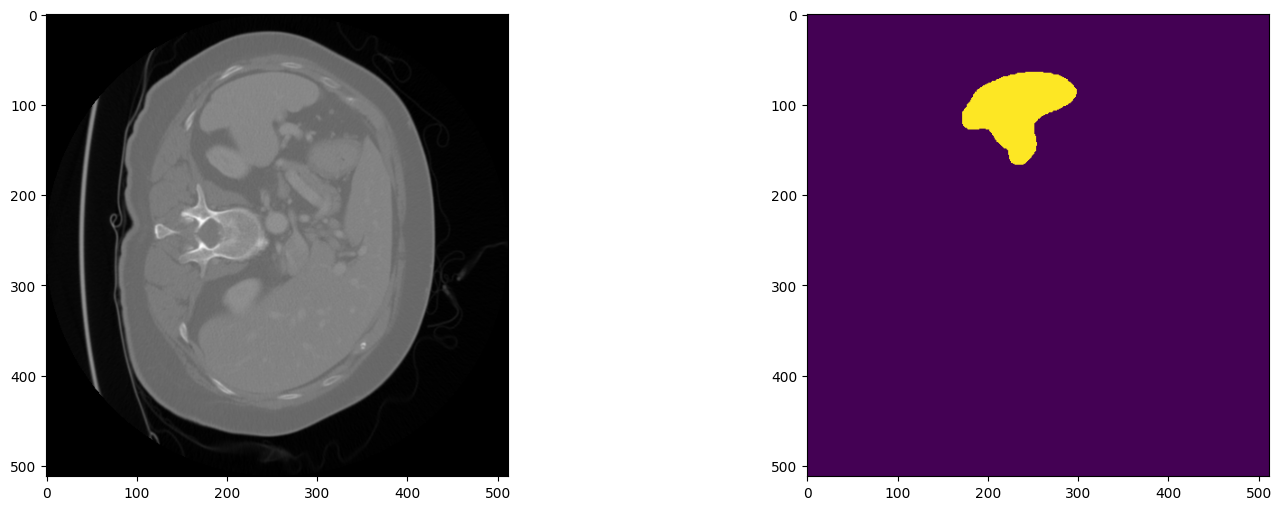

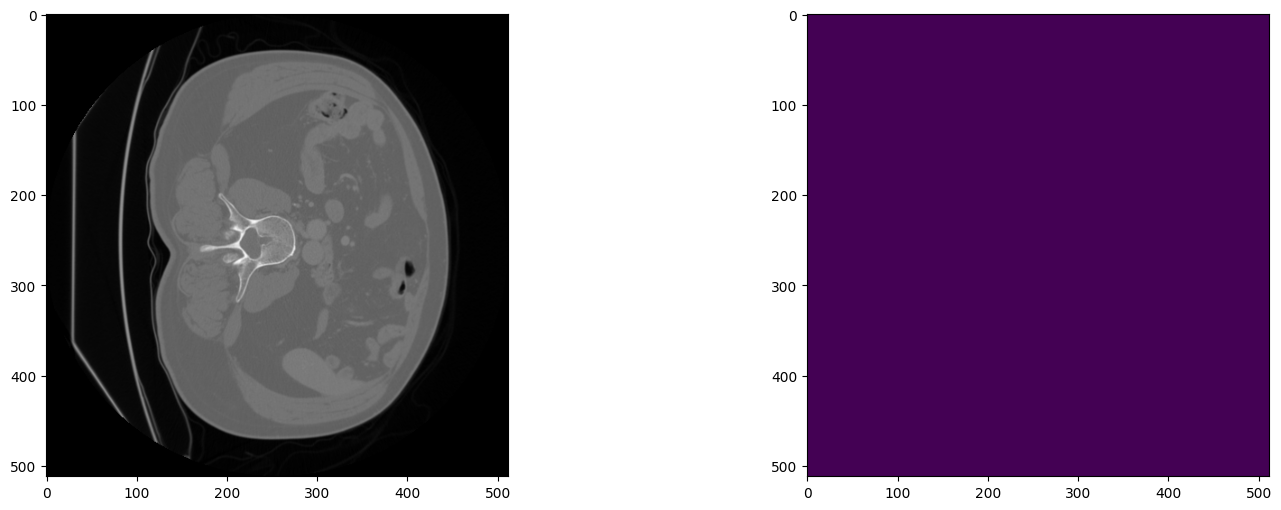

In [9]:
bundle_dir = "."
os.makedirs(bundle_dir, exist_ok=True)
download("spleen_ct_segmentation", bundle_dir=bundle_dir, progress=False)
weight_dir = os.path.join(bundle_dir, "spleen_ct_segmentation/models/model.pt")

config = MONAIUNetConfig()
monai_unet = MONAIUNet(config)
monai_unet.unet.load_state_dict(torch.load(weight_dir, weights_only=True))
pipeline = SpleenCTSegmentationPipeline(model=monai_unet, device=torch.device("cuda:0"), save_output=False)

numpy_transform = ToNumpy()
loader = LoadImage()


def convert_to_numpy(input):
    numpy_output = numpy_transform(input)
    numpy_output = np.squeeze(numpy_output, axis=0)
    return numpy_output


with torch.no_grad():
    test_outputs = pipeline(data_dicts[:2])
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Limpiar el directorio de datos

Elimina el directorio si se utilizó uno temporal.

Esta celda final se encarga de la limpieza, eliminando el directorio de datos temporal que se creó al principio del tutorial para no dejar archivos innecesarios en el sistema.

In [10]:
if directory is None:
    shutil.rmtree(root_dir)